Dataset Loaded Successfully!
Updated Column Names: Index(['match_id', 'innings', 'over', 'ball', 'batting_team', 'bowling_team',
       'runs_off_bat', 'extras', 'wicket', 'player_out', 'total_score'],
      dtype='object')


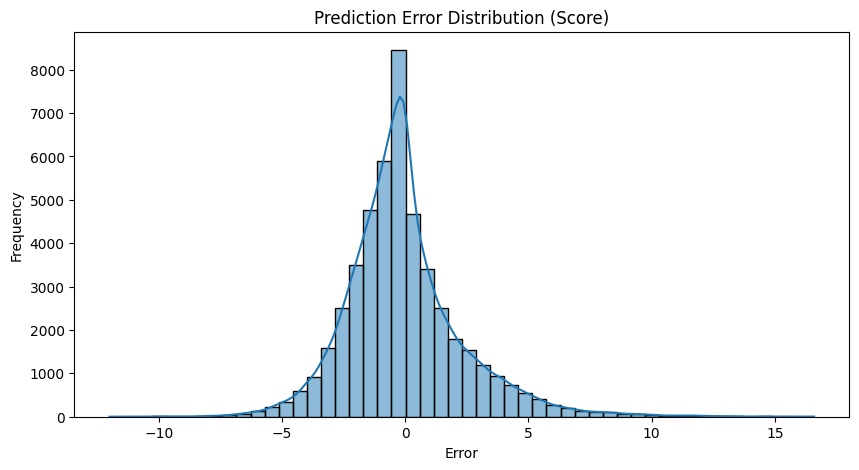

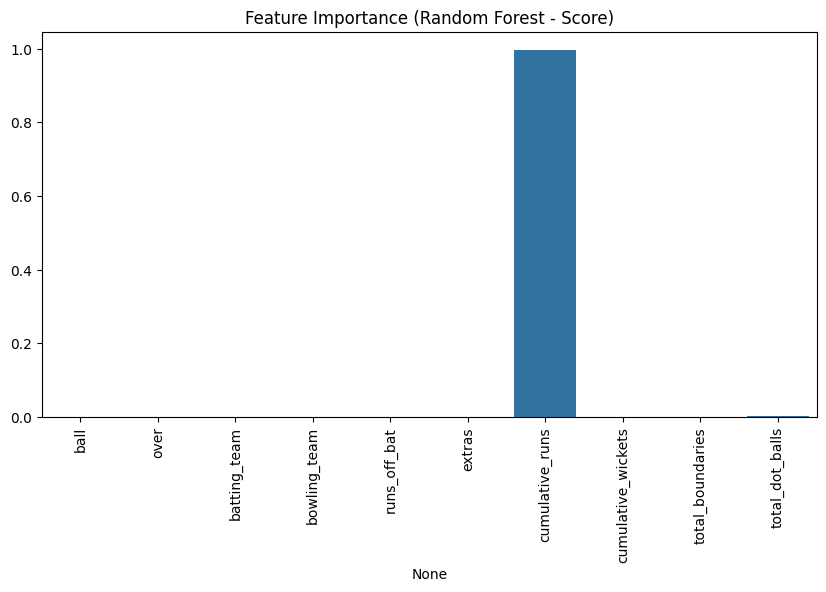

Predicted Final Score: 87
Predicted Wickets: 0
Predicted Boundaries: 0
Predicted Dot Balls: 0
Project Completed Successfully!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Enable inline plotting for Google Colab
%matplotlib inline

# **Step 1: Load the Dataset**
file_path = "/content/sample_data/ball_by_ball_ipl.csv"
df = pd.read_csv(file_path, on_bad_lines='skip').copy()
print("Dataset Loaded Successfully!")

# **Step 2: Select and Rename Relevant Columns**
df = df[['Match ID', 'Innings', 'Over', 'Ball', 'Bat First', 'Bat Second', 'Batter Runs', 'Extra Runs', 'Wicket', 'Player Out', 'Innings Runs']].copy()
df.rename(columns={
    'Match ID': 'match_id',
    'Innings': 'innings',
    'Over': 'over',
    'Ball': 'ball',
    'Bat First': 'batting_team',
    'Bat Second': 'bowling_team',
    'Batter Runs': 'runs_off_bat',
    'Extra Runs': 'extras',
    'Wicket': 'wicket',
    'Player Out': 'player_out',
    'Innings Runs': 'total_score'
}, inplace=True)

print("Updated Column Names:", df.columns)

# **Step 3: Handle Missing and Non-Numeric Values in 'ball' Column**
df['ball'] = pd.to_numeric(df['ball'], errors='coerce')
df.dropna(subset=['ball'], inplace=True)
df['ball'] = df['ball'].astype(int)

# **Step 4: Convert Team Names to Numerical Categories**
team_mapping = {team: i for i, team in enumerate(df['batting_team'].unique())}
df['batting_team'] = df['batting_team'].map(team_mapping)
df['bowling_team'] = df['bowling_team'].map(team_mapping)

# **Step 5: Feature Engineering**
df['cumulative_runs'] = df.groupby(['match_id', 'innings'])['runs_off_bat'].cumsum()
df['cumulative_wickets'] = df.groupby(['match_id', 'innings'])['wicket'].cumsum()
df['total_boundaries'] = df.groupby(['match_id', 'innings'])['runs_off_bat'].apply(lambda x: (x.isin([4, 6])).cumsum()).reset_index(level=[0, 1], drop=True)
df['total_dot_balls'] = df.groupby(['match_id', 'innings'])['runs_off_bat'].apply(lambda x: (x == 0).cumsum()).reset_index(level=[0, 1], drop=True)

# **Step 6: Train-Test Split for Multiple Predictions**
features = ['ball', 'over', 'batting_team', 'bowling_team', 'runs_off_bat', 'extras', 'cumulative_runs', 'cumulative_wickets', 'total_boundaries', 'total_dot_balls']
targets = ['total_score', 'cumulative_wickets', 'total_boundaries', 'total_dot_balls']

X = df[features]
y = df[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Step 7: Train Multiple Machine Learning Models**
rf_model_score = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model_wickets = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model_boundaries = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model_dot_balls = RandomForestRegressor(n_estimators=50, random_state=42)

rf_model_score.fit(X_train, y_train['total_score'])
rf_model_wickets.fit(X_train, y_train['cumulative_wickets'])
rf_model_boundaries.fit(X_train, y_train['total_boundaries'])
rf_model_dot_balls.fit(X_train, y_train['total_dot_balls'])

# **Step 8: Model Evaluation & Visualization**
y_pred_score = rf_model_score.predict(X_test)

plt.figure(figsize=(10, 5))
sns.histplot(y_test['total_score'] - y_pred_score, bins=50, kde=True)
plt.title("Prediction Error Distribution (Score)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 5))
importances = rf_model_score.feature_importances_
sns.barplot(x=X.columns, y=importances)
plt.xticks(rotation=90)
plt.title("Feature Importance (Random Forest - Score)")
plt.show()

# **Step 9: Function to Predict Multiple Values**
valid_teams = list(team_mapping.keys())

def predict_match_outcomes(current_ball, batting_team, bowling_team, current_runs, extras):
    if batting_team not in valid_teams or bowling_team not in valid_teams:
        return "Error: One or both teams not found in the dataset."

    batting_team_code = team_mapping[batting_team]
    bowling_team_code = team_mapping[bowling_team]

    input_data = [[current_ball, int(current_ball), batting_team_code, bowling_team_code, current_runs, extras, current_runs, 0, 0, 0]]
    input_df = pd.DataFrame(input_data, columns=features)

    predicted_score = round(rf_model_score.predict(input_df)[0])
    predicted_wickets = round(rf_model_wickets.predict(input_df)[0])
    predicted_boundaries = round(rf_model_boundaries.predict(input_df)[0])
    predicted_dot_balls = round(rf_model_dot_balls.predict(input_df)[0])

    # Ensure wickets never exceed 10
    if predicted_wickets >= 10:
        final_score = df[df['batting_team'] == batting_team_code]['total_score'].max()
        print(f"All wickets lost. Final predicted score: {final_score}")
        return final_score, 10, predicted_boundaries, predicted_dot_balls

    return predicted_score, predicted_wickets, predicted_boundaries, predicted_dot_balls

# **Example Usage**
predicted_score, predicted_wickets, predicted_boundaries, predicted_dot_balls = predict_match_outcomes(10.3, "Mumbai Indians", "Chennai Super Kings", 80, 5)
print(f"Predicted Final Score: {predicted_score}")
print(f"Predicted Wickets: {predicted_wickets}")
print(f"Predicted Boundaries: {predicted_boundaries}")
print(f"Predicted Dot Balls: {predicted_dot_balls}")

print("Project Completed Successfully!")
